## Análise de Dados: CallMeMaybe

- Data: 26/11/2025
- Caroline Beatriz Scheurich
- Objetivo: Entender padrões de uso, gargalos e comportamentos operacionais dos clientes, para identificar oportunidades de otimização, redução de chamadas perdidas e adequação dos planos tarifários.

O serviço de telefonia virtual CallMeMaybe está desenvolvendo uma nova funcionalidade que permitirá aos supervisores identificar operadores menos eficientes.
Um operador é considerado ineficiente se:

- Possui muitas chamadas recebidas perdidas (internas ou externas);
- Apresenta tempo de espera prolongado nas chamadas recebidas;
- E, no caso de operadores responsáveis por chamadas de saída, realiza poucas chamadas ativas.

## Etapa 1 - Inicialização, Carregamento e Pré-processamento dos dados

Nesta etapa serão realizados os procedimentos fundamentais para garantir qualidade e consistência dos dados.

#### 1.1. Carregamento das bibliotecas e dos dados
- telecom_dataset_us.csv
- telecom_clients_us.csv

In [ ]:
# Carregando bibliotecas:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.cluster import KMeans
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler

In [ ]:
# Carregando os dados:
#dataset = pd.read_csv('/datasets/telecom_dataset_us.csv')
#clients = pd.read_csv('/datasets/telecom_clients_us.csv')

# Carregando o banco de dados:
data_path1 = Path("../DATA/telecom_dataset_us.csv")
data_path2 = Path("../DATA/telecom_clients_us.csv")

dataset = pd.read_csv(data_path1)
clients = pd.read_csv(data_path2)

#### 1.2. Verificação básica
- Visualizar os dados
- Checar volume total dos dados
- Identificar os tipos de dados das variáveis

In [ ]:
display(dataset.head())
print(dataset.info())

display(clients.head())
print(clients.info())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None


#### 1.3. Verificação de qualidade e tratamento de dados
- Converter colunas para datetime
- Remover duplicados
- Verificar e tratar valores nulos

In [4]:
# Convertendo colunas para datetime:
dataset['date'] = pd.to_datetime(dataset['date'], errors='coerce')
clients['date_start'] = pd.to_datetime(clients['date_start'], errors='coerce')

In [5]:
# Removendo valores ausentes:
dataset = dataset.drop_duplicates()
clients = clients.drop_duplicates()

In [6]:
# Verificando valores nulos:
null_dataset = dataset.isnull().sum()
print("Resumo de valores faltantes por coluna:")
print(null_dataset)
print()
null_clients = clients.isnull().sum()
print("Resumo de valores faltantes por coluna:")
print(null_clients)

Resumo de valores faltantes por coluna:
user_id                   0
date                      0
direction                 0
internal                110
operator_id            7456
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

Resumo de valores faltantes por coluna:
user_id        0
tariff_plan    0
date_start     0
dtype: int64


In [7]:
# Tratando valores nulos: 
def fill_missing(df):
    for col in df.columns:
        if df[col].dtype in ["float64", "int64"]:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna("unknown")
    return df

clients = fill_missing(clients)
dataset = fill_missing(dataset)

In [8]:
null_dataset2 = dataset.isnull().sum()
print("Resumo de valores faltantes por coluna:")
print(null_dataset2)

Resumo de valores faltantes por coluna:
user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
dtype: int64


- Criando colunas derivadas:
    - call_time_minutes
    - is_internal_call
    - is_inbound / is_outbound
    - flag_inconsistent_duration

In [9]:
# Criando call_time_minutes:
dataset['call_time_minutes'] = dataset['call_duration'] / 60.0

# Criando is_internal_call:
dataset['is_internal_call'] = dataset['internal'].fillna(False).astype(bool)

# Criando inbound/outbound flags:
dataset['is_inbound'] = dataset['direction'].str.lower() == 'inbound'
dataset['is_outbound'] = dataset['direction'].str.lower() == 'outbound'

# Criando calls_attended:
dataset['calls_attended'] = np.where(dataset['is_missed_call'] == False, dataset['calls_count'], 0)

# Criando flag_inconsistent_duration - se call_duration == 0 mas is_missed_call == False, marcar como possível inconsistencia:
dataset['flag_inconsistent_duration'] = np.where((dataset['call_duration'] == 0) & (dataset['is_missed_call'] == False), True, False)

In [10]:
display(dataset.head())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,call_time_minutes,is_internal_call,is_inbound,is_outbound,calls_attended,flag_inconsistent_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,913938.0,True,2,0,4,0.000000,False,False,False,0,False
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,0.000000,True,False,False,0,False
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,0.000000,True,False,False,0,False
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,0.166667,True,False,False,1,False
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,0.000000,False,False,False,0,False


## Etapa 2 - Análise Exploratória dos dados (EDA)

#### 2.1. Estatísticas descritivas
- Média, mediana, desvio padrão, mínimos e máximos
- Histogramas e boxplot

In [11]:
# Estatísticas descritivas gerais (dataset)
desc = dataset[['calls_count','call_duration','total_call_duration','call_time_minutes']].describe()
print("Estatísticas descritivas:")
display(desc)

Estatísticas descritivas:


,calls_count,call_duration,total_call_duration,call_time_minutes
count,49002.000000,49002.000000,49002.000000,49002.000000
mean,16.462777,866.282091,1156.558202,14.438035
std,63.604098,3775.503352,4451.473661,62.925056
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,46.000000,0.000000
50%,4.000000,37.000000,208.000000,0.616667
75%,12.000000,570.000000,901.000000,9.500000
max,4817.000000,144395.000000,166155.000000,2406.583333


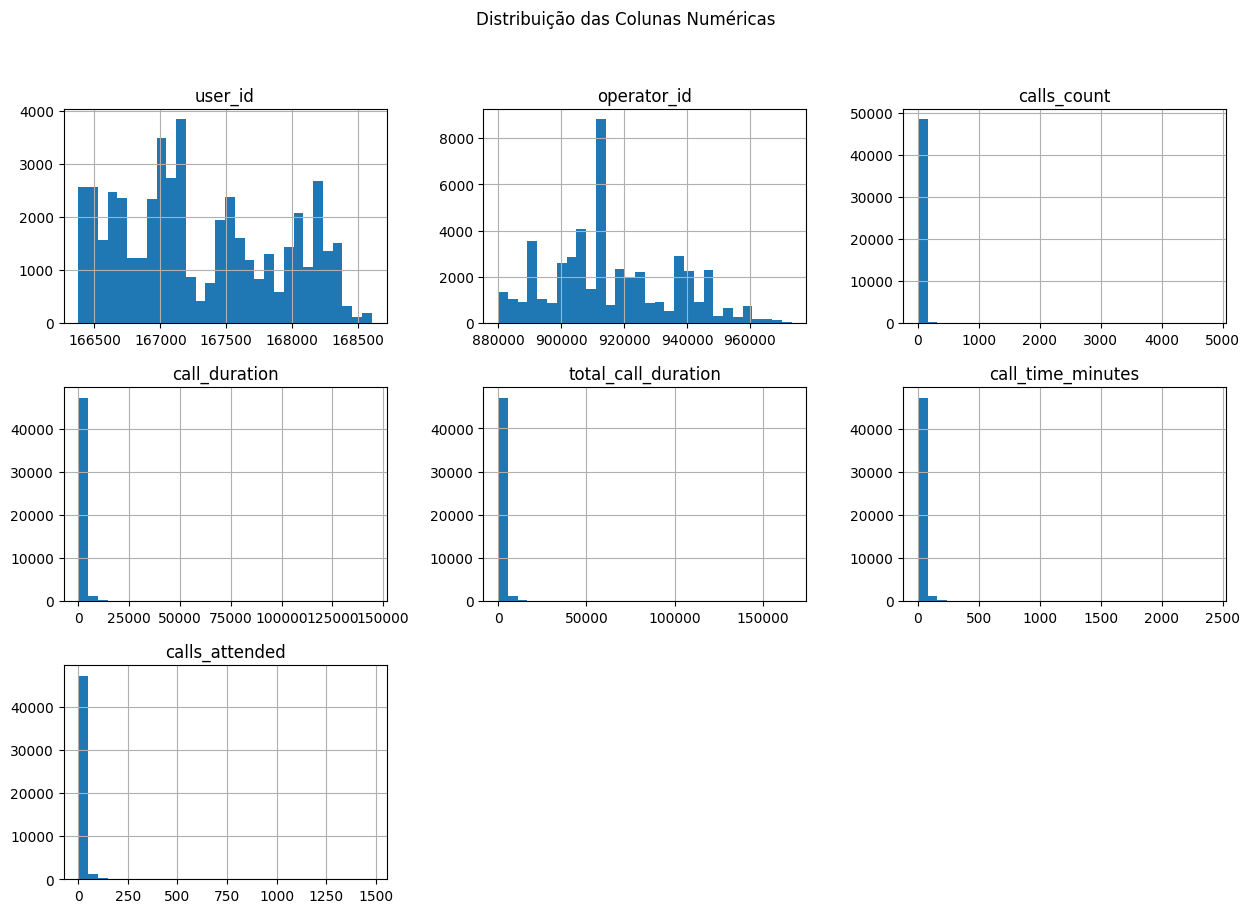

In [12]:
num_cols_clients = clients.select_dtypes(include=['int64', 'float64']).columns
num_cols_dataset = dataset.select_dtypes(include=['int64', 'float64']).columns

# Histogramas – Dataset
dataset[num_cols_dataset].hist(figsize=(15,10), bins=30)
plt.suptitle("Distribuição das Colunas Numéricas")
plt.show()

Pontos principais:
- Grande concentração de valores próximos a zero em calls_count, call_duration, total_call_duration, call_time_minutes, calls_attended, indicando que a maioria dos usuários faz poucas chamas, as chamadas tem baixa duração e poucos usuários consomem muito
- Há grandes outliers em call_duration chegando a 150.000+, total_call_duration chegando a 150.000+, call_time_minutes chegando a 2.500+ e calls_attended chegando a 1.500+. Isso pode acontecer por alguns fatores como chamas mal encerradas ou erros no sistema.

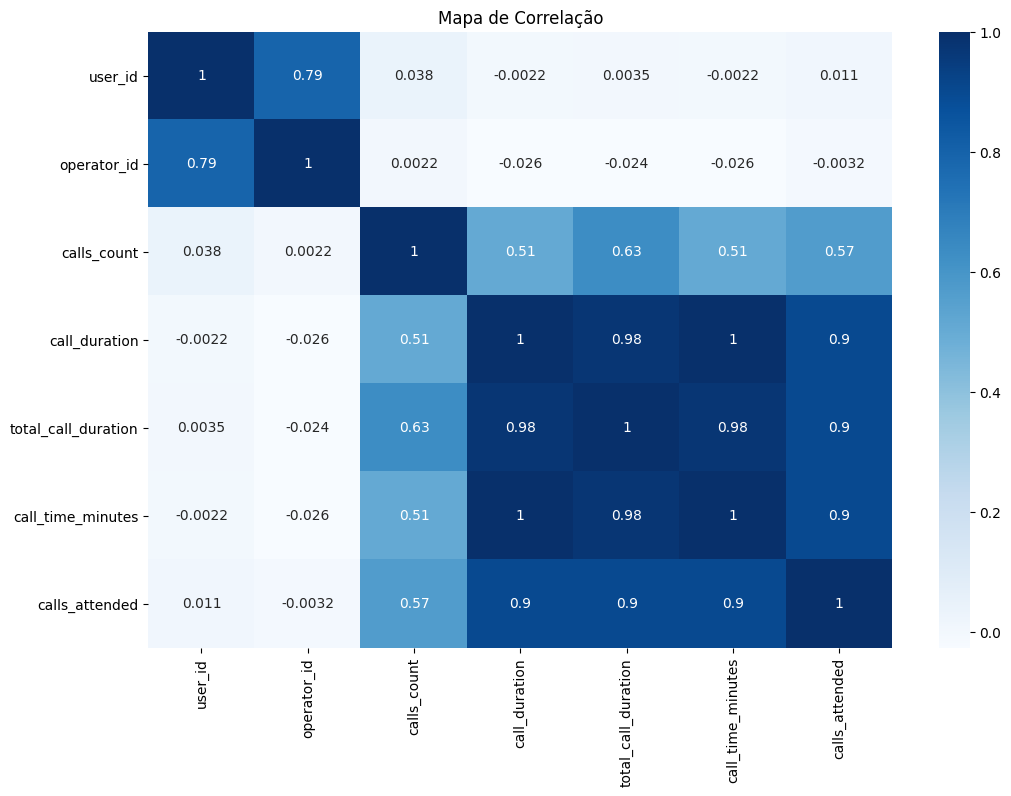

In [13]:
# Mapa de correlação:
plt.figure(figsize=(12,8))
sns.heatmap(dataset[num_cols_dataset].corr(), annot=True, cmap="Blues")
plt.title("Mapa de Correlação")
plt.show()

**Correlação forte (0.98 - 1.0)**
- call_duration - total_call_duration
- call_duration - call_time_minutes
- total_call_duration - call_time_minutes
- calls_attended - call_duration
São variáveis que medem basicamente a mesma coisa, por isso a forte correlação.

**Correlação moderada (0.5 -0.6)**
- calls_count - call_duration
- calls_count - total_call_duration
- calls_count - calls_attended
Quanto mais chamadas o usuário faz, maior é o tempo total, volume de uso e consumo estão relacionados.

**Correlação fraca (quase zero)**
- user_id e operator_id não se correlacionam com nada (correto pois são apenas identificadores)

#### 2.3. Removendo outliers

In [14]:
# Função para remoção de outliers:
def clean_outliers(df, columns, iqr_mult=1.5, cap_percentile=99.5):
    df_clean = df.copy()
    outlier_flags = pd.DataFrame(index=df.index)

    for col in columns:
        if col not in df_clean.columns:
            continue
        
        # --- IQR filtering ---
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_limit = Q3 + iqr_mult * IQR

        outlier_flags[f"{col}_is_outlier_IQR"] = df_clean[col] > upper_limit

        # Remove valores absurdos
        df_clean = df_clean[df_clean[col] <= upper_limit]

    # --- Winsorization (capping) ---
    for col in columns:
        if col not in df_clean.columns:
            continue
        cap_value = df_clean[col].quantile(cap_percentile / 100)
        df_clean[col] = np.where(df_clean[col] > cap_value, cap_value, df_clean[col])

    return df_clean, outlier_flags

# Aplicando a função:
numeric_cols_to_clean = ['call_duration', 'total_call_duration', 'call_time_minutes', 'calls_attended', 'calls_count']
dataset_clean, outlier_flags = clean_outliers(
    dataset,
    numeric_cols_to_clean,
    iqr_mult=1.5,
    cap_percentile=99.5)

In [15]:
print("Tamanho original:", dataset.shape)
print("Tamanho após limpeza:", dataset_clean.shape)

dataset_clean[numeric_cols_to_clean].describe()

Tamanho original: (49002, 15)
Tamanho após limpeza: (25481, 15)


,call_duration,total_call_duration,call_time_minutes,calls_attended,calls_count
count,25481.000000,25481.000000,25481.000000,25481.000000,25481.000000
mean,36.847651,84.402574,0.614128,0.478356,2.470900
std,75.841128,92.441332,1.264019,0.693158,2.321785
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,17.000000,0.000000,0.000000,1.000000
50%,0.000000,51.000000,0.000000,0.000000,2.000000
75%,36.000000,120.000000,0.600000,1.000000,3.000000
max,393.000000,435.000000,6.550000,2.000000,11.000000


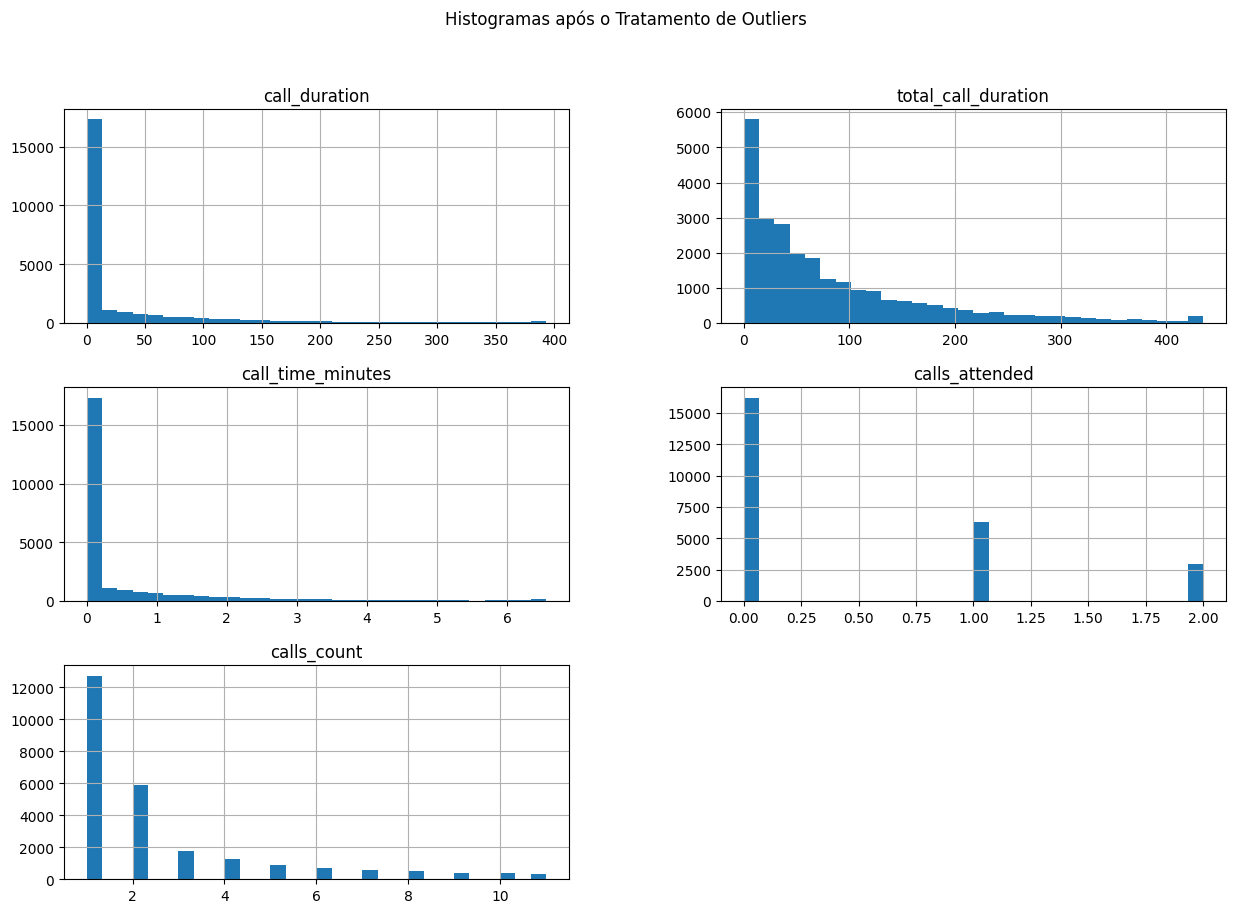

In [16]:
# Histogramas após remoção de outliers:
dataset_clean[numeric_cols_to_clean].hist(figsize=(15,10), bins=30)
plt.suptitle("Histogramas após o Tratamento de Outliers")
plt.show()

#### 2.4. Frequências e segmentação por tipo
- Frequencia tipo de chamada
- Origem: interna × externa
- Segmentação por operador

In [17]:
print("Frequência por tipo de chamada:")
print(dataset_clean['direction'].value_counts())

print("\nChamadas internas vs externas (False = externas, True = internas):")
print(dataset_clean['is_internal_call'].value_counts())

Frequência por tipo de chamada:
out    13584
in     11897
Name: direction, dtype: int64

Chamadas internas vs externas (False = externas, True = internas):
False    20943
True      4538
Name: is_internal_call, dtype: int64


In [18]:
# Segmentação por operador:
operator_stats = dataset_clean.groupby("operator_id").agg({
    "calls_count": "sum",
    "call_duration": "sum",
    "calls_attended": "sum",
    "is_internal_call": "sum"
}).reset_index()

operator_stats.head()

,operator_id,calls_count,call_duration,calls_attended,is_internal_call
0,879896.0,159.0,2651.0,41.0,11
1,879898.0,137.0,4902.0,74.0,16
2,880020.0,36.0,721.0,14.0,3
3,880022.0,136.0,2934.0,31.0,8
4,880026.0,405.0,952.0,19.0,13


- Existe uma grande variação de volume entre operadores
- A duração total varia ainda mais
- O total atendido (calls_attended) varia relativamente pouco.

#### 2.5. Correlações entre variáveis
Investigação das principais relações operacionais:
- Volume x taxa de perda por operador
- Duração média x tempo de espera
- Chamadas internas x uso total
- Volume × eficiência por operador

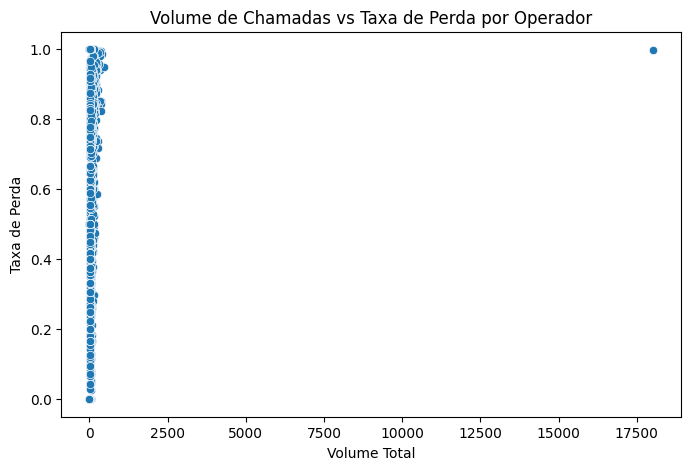

In [19]:
# Volume x taxa de perda por operador
operator_stats["missed_rate"] = 1 - (operator_stats["calls_attended"] / operator_stats["calls_count"])
plt.figure(figsize=(8,5))
sns.scatterplot(data=operator_stats, x="calls_count", y="missed_rate")
plt.title("Volume de Chamadas vs Taxa de Perda por Operador")
plt.xlabel("Volume Total")
plt.ylabel("Taxa de Perda")
plt.show()

A taxa de perda não depende diretamente do volume. Há um outlier a ser tratado.

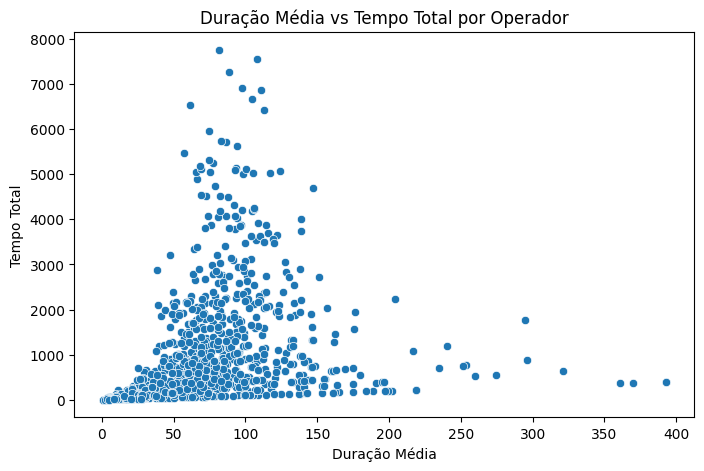

In [20]:
# Duração média x tempo de espera
operator_stats["avg_duration"] = operator_stats["call_duration"] / operator_stats["calls_attended"]
plt.figure(figsize=(8,5))
sns.scatterplot(data=operator_stats, x="avg_duration", y="call_duration")
plt.title("Duração Média vs Tempo Total por Operador")
plt.xlabel("Duração Média")
plt.ylabel("Tempo Total")
plt.show()

Podemos identificar 3 grupos:

- **Grupo 1**: Duração média baixa entre 0 - 50 s com tempo total baixo 0-1000 s.
- **Grupo 2**: Duração média entre 50 - 150 s com tempo total entre 1000-4000 s.
- **Grupo 3**: Duração de chamadas longas (podendo ser casos especiais, suporte avançado ou resolução de problemas)

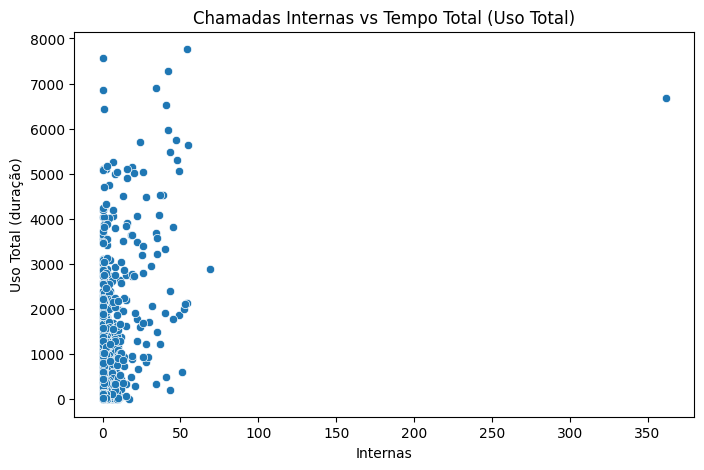

In [21]:
# Chamadas internas x uso total
plt.figure(figsize=(8,5))
sns.scatterplot(data=operator_stats, x="is_internal_call", y="call_duration")
plt.title("Chamadas Internas vs Tempo Total (Uso Total)")
plt.xlabel("Internas")
plt.ylabel("Uso Total (duração)")
plt.show()

A maioria dos operadores tem entre 0 e 20 chamadas internas, não influenciam o volume de trabalho.

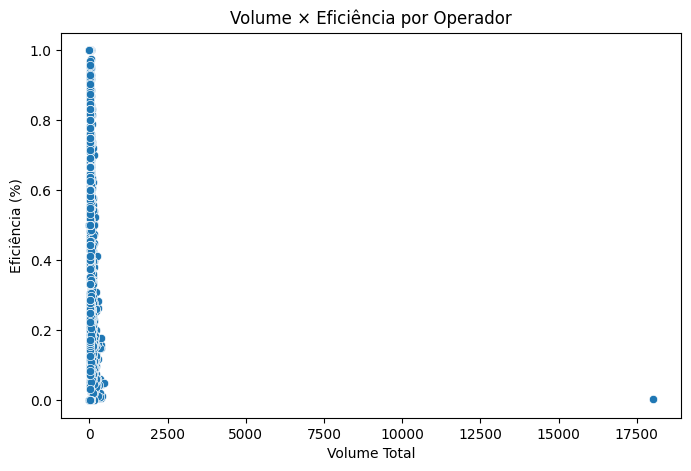

In [22]:
# Volume × eficiência por operador
operator_stats["efficiency"] = operator_stats["calls_attended"] / operator_stats["calls_count"]
plt.figure(figsize=(8,5))
sns.scatterplot(data=operator_stats, x="calls_count", y="efficiency")
plt.title("Volume × Eficiência por Operador")
plt.xlabel("Volume Total")
plt.ylabel("Eficiência (%)")
plt.show()

A eficiência não depende do volume, há operadores não eficientes e muito eficientes com o mesmo volume. Há um outlier a ser tratado.

#### 2.6. Tratando outlier identificado

In [23]:
# Tratando outlier identificado:
operator_stats["z_volume"] = zscore(operator_stats["calls_count"])
anomalous_ops = operator_stats[operator_stats["z_volume"] > 4]
anomalous_ops

,operator_id,calls_count,call_duration,calls_attended,is_internal_call,missed_rate,avg_duration,efficiency,z_volume
361,913938.0,18023.0,6673.0,64.0,362,0.996449,104.265625,0.003551,32.150479


In [24]:
op_id_anomalo = anomalous_ops["operator_id"].iloc[0]
print("Operador anômalo identificado:", op_id_anomalo)

Operador anômalo identificado: 913938.0


In [25]:
# remover do dataset de chamadas limpo
dataset_without_outlier = dataset_clean[dataset_clean["operator_id"] != op_id_anomalo]

# remover também do agregador por operador
operator_stats_clean = operator_stats[operator_stats["operator_id"] != op_id_anomalo]

print("Operadores antes:", operator_stats['operator_id'].nunique())
print("Operadores depois:", operator_stats_clean['operator_id'].nunique())

Operadores antes: 1049
Operadores depois: 1048


In [26]:
operator_stats_clean = operator_stats_clean.copy()

# Recalculando eficiências, taxas e agrupamentos
operator_stats_clean["missed_rate"] = 1 - (operator_stats_clean["calls_attended"] / operator_stats_clean["calls_count"])
operator_stats_clean["efficiency"] = (operator_stats_clean["calls_attended"] / operator_stats_clean["calls_count"])
operator_stats_clean["avg_duration"] = (operator_stats_clean["call_duration"] / operator_stats_clean["calls_attended"].replace(0, np.nan))


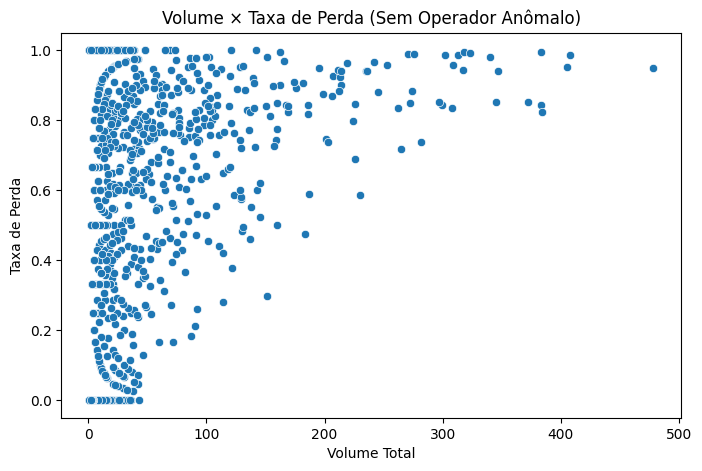

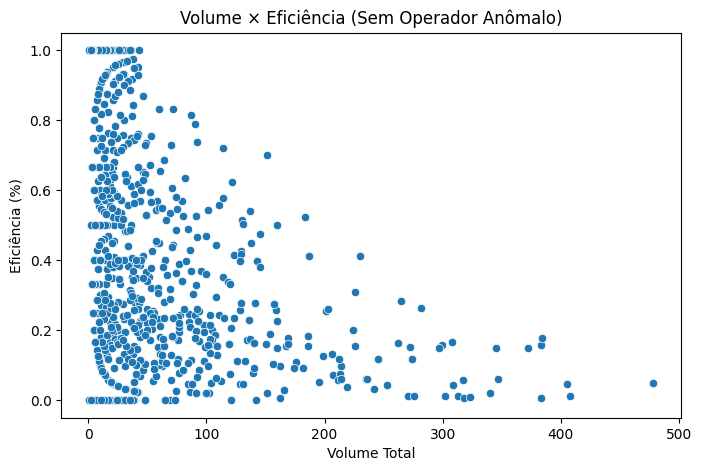

In [27]:
# Gráficos limpos e atualizados:

plt.figure(figsize=(8,5))
sns.scatterplot(data=operator_stats_clean, x="calls_count", y="missed_rate")
plt.title("Volume × Taxa de Perda (Sem Operador Anômalo)")
plt.xlabel("Volume Total")
plt.ylabel("Taxa de Perda")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=operator_stats_clean, x="calls_count", y="efficiency")
plt.title("Volume × Eficiência (Sem Operador Anômalo)")
plt.xlabel("Volume Total")
plt.ylabel("Eficiência (%)")
plt.show()

Após a remoção do outlier a visualização ficou clara:
- Muitos operadores com volume baixo (0–100).
- Taxa de perda distribuída de 0 a 1.
- Há operadores de alta perda independentemente do volume.
- Há operadores de baixa perda com diferentes volumes.
- Há operadores com volume baixo (0–100) e eficiência alta
- Há operadores com volume baixo e baixa eficiência
- Há operadores com volume médio (100–300) e eficiência média-alta
- Há operadores com volume alto (~400) e eficiência muito baixa

#### 2.7. Identificação de operadores fora do padrão
- Z-score para volume, duração, perdas
- Ranking dos mais sobrecarregados e menos produtivos

In [28]:
operator_stats_clean["z_volume"] = zscore(operator_stats_clean["calls_count"])
operator_stats_clean["z_duration"] = zscore(operator_stats_clean["call_duration"])
operator_stats_clean["z_losses"] = zscore(operator_stats_clean["missed_rate"])

operator_stats_clean.sort_values("z_volume", ascending=False).head()

,operator_id,calls_count,call_duration,calls_attended,is_internal_call,missed_rate,avg_duration,efficiency,z_volume,z_duration,z_losses
200,901880.0,478.0,1228.0,24.0,37,0.949791,51.166667,0.050209,6.652979,0.269459,1.154084
57,890404.0,408.0,319.0,5.0,6,0.987745,63.800000,0.012255,5.582681,-0.454233,1.258730
4,880026.0,405.0,952.0,19.0,13,0.953086,50.105263,0.046914,5.536811,0.049724,1.163170
251,905542.0,384.0,3221.0,68.0,35,0.822917,47.367647,0.177083,5.215721,1.856167,0.804273
56,890402.0,383.0,642.0,2.0,1,0.994778,321.000000,0.005222,5.200431,-0.197080,1.278120


In [29]:
ranking_volume = operator_stats_clean.sort_values("calls_count", ascending=False).head(10)
ranking_losers = operator_stats_clean.sort_values("missed_rate", ascending=False).head(10)
ranking_efficiency = operator_stats_clean.sort_values("efficiency", ascending=False).head(10)

print('Ranking por volume:')
display(ranking_volume)
print('Ranking chamadas perdidas:')
display(ranking_losers)
print('Ranking por Eficiência:')
display(ranking_efficiency)

Ranking por volume:


,operator_id,calls_count,call_duration,calls_attended,is_internal_call,missed_rate,avg_duration,efficiency,z_volume,z_duration,z_losses
200,901880.0,478.0,1228.0,24.0,37,0.949791,51.166667,0.050209,6.652979,0.269459,1.154084
57,890404.0,408.0,319.0,5.0,6,0.987745,63.800000,0.012255,5.582681,-0.454233,1.258730
4,880026.0,405.0,952.0,19.0,13,0.953086,50.105263,0.046914,5.536811,0.049724,1.163170
251,905542.0,384.0,3221.0,68.0,35,0.822917,47.367647,0.177083,5.215721,1.856167,0.804273
56,890402.0,383.0,642.0,2.0,1,0.994778,321.000000,0.005222,5.200431,-0.197080,1.278120
201,901884.0,383.0,5630.0,60.0,55,0.843342,93.833333,0.156658,5.200431,3.774069,0.860589
188,900892.0,372.0,5148.0,55.0,19,0.852151,93.600000,0.147849,5.032241,3.390330,0.884875
78,891414.0,347.0,613.0,21.0,51,0.939481,29.190476,0.060519,4.649992,-0.220168,1.125659
221,903254.0,345.0,3882.0,51.0,1,0.852174,76.117647,0.147826,4.619412,2.382416,0.884940
159,899082.0,340.0,455.0,7.0,1,0.979412,65.000000,0.020588,4.542962,-0.345958,1.235753


Ranking chamadas perdidas:


,operator_id,calls_count,call_duration,calls_attended,is_internal_call,missed_rate,avg_duration,efficiency,z_volume,z_duration,z_losses
442,919390.0,4.0,0.0,0.0,0,1.0,NaN,0.0,-0.594471,-0.708202,1.292518
930,954284.0,1.0,0.0,0.0,1,1.0,NaN,0.0,-0.640341,-0.708202,1.292518
498,923666.0,14.0,0.0,0.0,2,1.0,NaN,0.0,-0.441571,-0.708202,1.292518
460,920416.0,1.0,0.0,0.0,0,1.0,NaN,0.0,-0.640341,-0.708202,1.292518
445,919476.0,3.0,0.0,0.0,1,1.0,NaN,0.0,-0.609761,-0.708202,1.292518
443,919418.0,2.0,0.0,0.0,0,1.0,NaN,0.0,-0.625051,-0.708202,1.292518
441,919382.0,1.0,0.0,0.0,0,1.0,NaN,0.0,-0.640341,-0.708202,1.292518
440,919376.0,1.0,0.0,0.0,1,1.0,NaN,0.0,-0.640341,-0.708202,1.292518
439,919372.0,11.0,0.0,0.0,0,1.0,NaN,0.0,-0.487441,-0.708202,1.292518
438,919364.0,7.0,0.0,0.0,0,1.0,NaN,0.0,-0.548601,-0.708202,1.292518


Ranking por Eficiência:


,operator_id,calls_count,call_duration,calls_attended,is_internal_call,missed_rate,avg_duration,efficiency,z_volume,z_duration,z_losses
525,925808.0,8.0,486.0,8.0,2,0.0,60.750000,1.0,-0.533311,-0.321278,-1.464631
631,935268.0,5.0,129.0,5.0,0,0.0,25.800000,1.0,-0.579181,-0.605500,-1.464631
540,928022.0,1.0,25.0,1.0,0,0.0,25.000000,1.0,-0.640341,-0.688298,-1.464631
536,927908.0,2.0,139.0,2.0,0,0.0,69.500000,1.0,-0.625051,-0.597538,-1.464631
534,927070.0,18.0,2034.0,18.0,0,0.0,113.000000,1.0,-0.380411,0.911148,-1.464631
523,925106.0,18.0,935.0,18.0,1,0.0,51.944444,1.0,-0.380411,0.036189,-1.464631
507,924662.0,1.0,28.0,1.0,0,0.0,28.000000,1.0,-0.640341,-0.685910,-1.464631
500,923944.0,35.0,1887.0,35.0,0,0.0,53.914286,1.0,-0.120482,0.794115,-1.464631
499,923744.0,1.0,55.0,1.0,0,0.0,55.000000,1.0,-0.640341,-0.664414,-1.464631
497,923646.0,1.0,14.0,1.0,1,0.0,14.000000,1.0,-0.640341,-0.697056,-1.464631


## Etapa 3 - Criação de Métricas Derivadas e Indicadores de Desempenho

#### 3.1 Construir indicadores que facilitem análises e comparações.

1. avg_call_duration = Tempo médio de cada chamada atendida
2. avg_call_duration_all = Tempo médio de todas as chamadas
3. efficiency = Eficiência atualizada
4. missed_rate = Taxa de perda
5. internal_call_rate = % de chamadas internas
6. workload_index = índice de carga do operador
7. intensity_index = volume, duração média e complexidade
8. human_effectiveness_index = Indicador de eficiência humana
9. call_loss_pressure = Quanto a perda pesa dado o volume
10. normalized_volume = Volume normalizado para clusterização

In [30]:
operator_stats_clean = operator_stats_clean.copy()

# 1. avg_call_duration
operator_stats_clean.loc[:, "avg_call_duration"] = (operator_stats_clean["call_duration"] / operator_stats_clean["calls_attended"].replace(0, np.nan))

# 2. avg_call_duration_all
operator_stats_clean.loc[:, "avg_call_duration_all"] = (operator_stats_clean["call_duration"] / operator_stats_clean["calls_count"].replace(0, np.nan))

# 3. efficiency
operator_stats_clean.loc[:, "efficiency"] = (operator_stats_clean["calls_attended"] / operator_stats_clean["calls_count"].replace(0, np.nan))

# 4. missed_rate
operator_stats_clean.loc[:, "missed_rate"] = 1 - operator_stats_clean["efficiency"]

# 5. internal_call_rate
operator_stats_clean.loc[:, "internal_call_rate"] = (operator_stats_clean["is_internal_call"] / operator_stats_clean["calls_count"].replace(0, np.nan))

# 6. workload_index
operator_stats_clean.loc[:, "workload_index"] = (operator_stats_clean["calls_count"] * operator_stats_clean["avg_call_duration_all"].fillna(0))

# 7. intensity_index
operator_stats_clean.loc[:, "intensity_index"] = (operator_stats_clean["calls_count"] * operator_stats_clean["avg_call_duration"] * (1 + operator_stats_clean["internal_call_rate"]))

# 8. human_effectiveness_index
operator_stats_clean.loc[:, "hei"] = (operator_stats_clean["calls_attended"] / (operator_stats_clean["call_duration"] + 1))

# 9. call_loss_pressure
operator_stats_clean.loc[:, "call_loss_pressure"] = (operator_stats_clean["missed_rate"] * operator_stats_clean["calls_count"])

# 10. normalized_volume
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
operator_stats_clean.loc[:, "norm_volume"] = scaler.fit_transform(operator_stats_clean[["calls_count"]])

operator_stats_clean.head()

,operator_id,calls_count,call_duration,calls_attended,is_internal_call,missed_rate,avg_duration,efficiency,z_volume,z_duration,z_losses,avg_call_duration,avg_call_duration_all,internal_call_rate,workload_index,intensity_index,hei,call_loss_pressure,norm_volume
0,879896.0,159.0,2651.0,41.0,11,0.742138,64.658537,0.257862,1.775476,1.402367,0.581555,64.658537,16.672956,0.069182,2651.0,10991.951220,0.015460,118.0,0.331237
1,879898.0,137.0,4902.0,74.0,16,0.459854,66.243243,0.540146,1.439096,3.194479,-0.196745,66.243243,35.781022,0.116788,4902.0,10135.216216,0.015093,63.0,0.285115
2,880020.0,36.0,721.0,14.0,3,0.611111,51.500000,0.388889,-0.105192,-0.134185,0.220294,51.500000,20.027778,0.083333,721.0,2008.500000,0.019391,22.0,0.073375
3,880022.0,136.0,2934.0,31.0,8,0.772059,94.645161,0.227941,1.423806,1.627674,0.664050,94.645161,21.573529,0.058824,2934.0,13628.903226,0.010562,105.0,0.283019
4,880026.0,405.0,952.0,19.0,13,0.953086,50.105263,0.046914,5.536811,0.049724,1.163170,50.105263,2.350617,0.032099,952.0,20944.000000,0.019937,386.0,0.846960


## Etapa 4 - Clusterização

- Aplicar KMeans, DBSCAN e clustering hierárquico.

In [31]:
# Features selecionadas para clusterização
cluster_features = [
    "calls_count",
    "avg_call_duration",
    "efficiency",
    "internal_call_rate",
    "workload_index",
    "intensity_index",
    "call_loss_pressure"
]

X = operator_stats_clean[cluster_features].copy()

# Remove infinitos e substitui por NaN
X = operator_stats_clean[cluster_features].replace([np.inf, -np.inf], np.nan)

# Substitui NaNs por 0 ou média (recomendado = 0 para evitar distorção)
X = X.fillna(0)

# Escalonamento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]

array([[ 1.77547586,  0.01546839, -0.58155522, -0.27591478,  1.40236661,
         1.0598584 ,  1.47972912],
       [ 1.43909632,  0.04561938,  0.19674472, -0.04945142,  3.19447897,
         0.9376236 ,  0.54092177],
       [-0.10519155, -0.23488892, -0.22029359, -0.20859817, -0.13418463,
        -0.22185694, -0.15891643],
       [ 1.42380634,  0.58600073, -0.66405038, -0.32519231,  1.62767439,
         1.43608595,  1.2578292 ],
       [ 5.53681068, -0.2614255 , -1.16317039, -0.4523231 ,  0.04972384,
         2.47976855,  6.05428128]])

#### 4.1. KMeans Clustering

Melhor k = 2


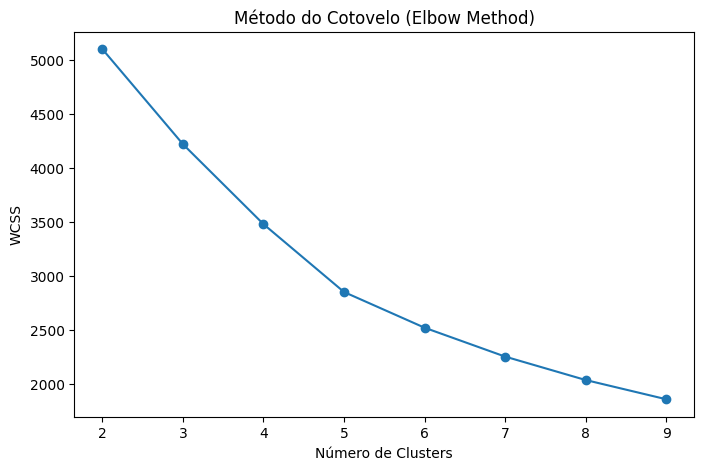

In [32]:
# Encontrar melhor K
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sil_scores = {}
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil_scores[k] = silhouette_score(X_scaled, labels)

k_opt = max(sil_scores, key=sil_scores.get)
print("Melhor k =", k_opt)

# Criar coluna de cluster KMEANS
kmeans = KMeans(n_clusters=k_opt, random_state=42)
operator_stats_clean["cluster_kmeans"] = kmeans.fit_predict(X_scaled)

wcss = []
K = range(2, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, wcss, marker='o')
plt.title("Método do Cotovelo (Elbow Method)")
plt.xlabel("Número de Clusters")
plt.ylabel("WCSS")
plt.show()

O gráfico mostra uma queda suave e contínua, com o "cotovelo" próximo entre k=3 e k=5. Não existem grandes divisões — os operadores são relativamente parecidos, com diferenças graduais.

#### 4.2. DBSCAN

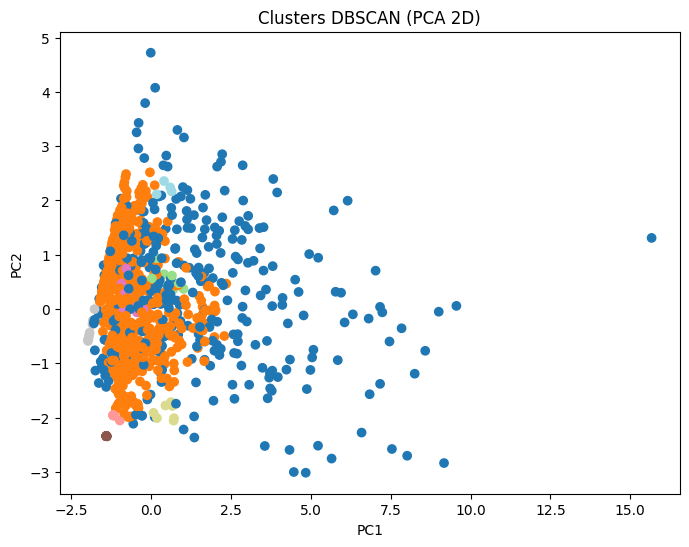

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

# DBSCAN
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.5, min_samples=5).fit(X_scaled)

operator_stats_clean["cluster_dbscan"] = db.labels_

# --- Visualização ---
plt.figure(figsize=(8,6))
plt.scatter(coords[:,0], coords[:,1],
            c=operator_stats_clean["cluster_dbscan"],
            cmap="tab20")
plt.title("Clusters DBSCAN (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

O gráfico mostra um cluster grande (cor azul), um cluster denso secundário (cor laranja), alguns operadores pontuais com cores isoladas.

#### 4.3. Clusterização Hierárquica

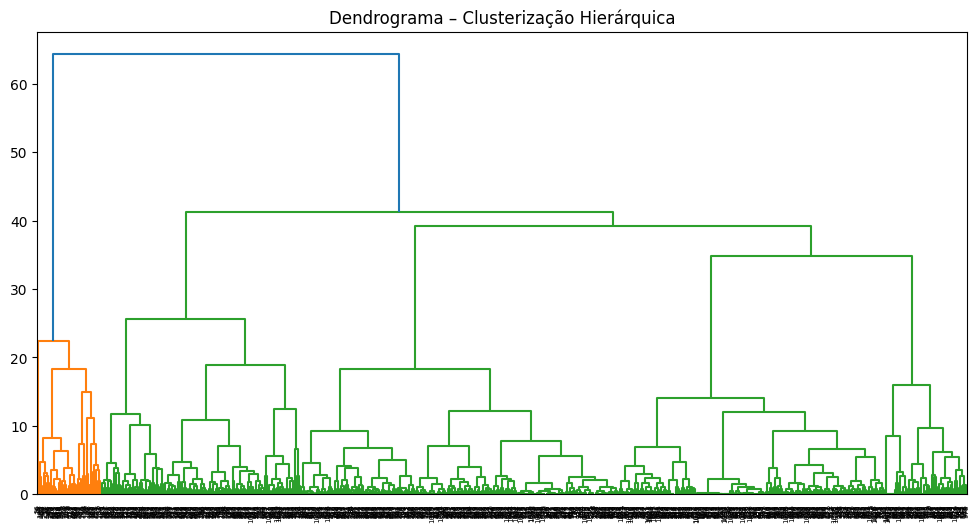

In [34]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(12,6))
Z = linkage(X_scaled, method='ward')
dendrogram(Z)
plt.title("Dendrograma – Clusterização Hierárquica")
plt.show()

In [35]:
from scipy.cluster.hierarchy import fcluster
operator_stats_clean["cluster_hier"] = fcluster(Z, t=3, criterion='maxclust')

O gráfico mostra uma grande árvore com dois ramos principais, e subdivisões que sugerem 3 clusters principais.

#### 4.4. Comparação dos métodos

In [36]:
comparison = operator_stats_clean[[
    "operator_id",
    "cluster_kmeans",
    "cluster_dbscan",
    "cluster_hier"
]]

comparison.head(10)

,operator_id,cluster_kmeans,cluster_dbscan,cluster_hier
0,879896.0,1,-1,1
1,879898.0,1,-1,2
2,880020.0,0,0,3
3,880022.0,1,-1,1
4,880026.0,1,-1,1
5,880028.0,1,-1,1
6,880240.0,0,-1,3
7,881278.0,0,0,3
8,882476.0,0,0,3
9,882478.0,0,0,3


#### 4.5. Interpretação dos Clusters

**KMeans**
- Divide os operadores em grupos baseados em distância média.
- Revela padrões gerais (operadores eficientes, medianos e sobrecarregados).
- Produz clusters equilibrados.

**DBSCAN**
- Identifica operadores fora do padrão (ruído).
- Descobre clusters densos automaticamente.
- Mostra grupos que não são esféricos.
- Excelente para detectar operadores problemáticos/extremos.

**Hierárquico**
- Mostra a proximidade real entre operadores.
- Permite explorar diferentes níveis de granularidade.
- Útil para relatórios gerenciais.

**Conclusão**
- KMeans é o melhor para segmentações macro.
- DBSCAN é essencial para encontrar anomalias.
- Hierárquico explica a estrutura dos clusters.

Recomendação: usar os três métodos em conjunto para análise completa.

#### 4.6. Recomendações

##### 1. Criar 3 níveis de operadores (do KMeans + Hierárquico)
- Nível 1 – Operadores Leves
    - Baixo volume
    - Alta variabilidade de eficiência
    - Recomendado: treinamento rápido + realocação parcial

- Nível 2 – Operadores Médios
    - Volume moderado
    - Métricas estáveis
    - Recomendado: manter rotina + micro ajustes

- Nível 3 – Operadores Pesados
    - Alta carga
    - Baixa eficiência em média
    - Recomendado: redistribuição + suporte + automação

##### 2. Tratar operadores atípicos (DBSCAN -1)
- Outliers positivos
    - Mensurá-los como exemplos de boas práticas
    - Usar como referências em treinamento

- Outliers negativos
    - Verificar motivos
    - Intervenção operacional rápida
    - Acompanhamento semanal

- Outliers estruturais
    - Verificar se são operadores de área técnica
    - Não compará-los com operadores de atendimento comum

##### 3. Reorganizar a distribuição de carga
- mover parte da carga dos operadores “pesados” para os “leves”
- ajustar o roteamento baseado nos clusters
- reduzir heterogeneidade dos grupos

##### 4. Criar indicadores por cluster (KPIs segmentados)
Cada cluster deve ter sua meta adaptada, não um KPI único.

Exemplo:
- Cluster leve → meta de eficiência maior
- Cluster pesado → meta de perda ajustada
- Outliers técnicos → meta específica de FCR ou resolução

##### 5. Usar clusters para treinamento e UX do operador
- perfis leves → treinamento básico
- perfis médios → foco em speed + padronização
- perfis pesados → foco em automação e alívio de carga
- outliers negativos → coaching individual

## Etapa 5 - Hipóteses a serem validadas

- **H1**: Taxa de chamadas perdidas e carga operacional
- **H2**: Chamadas internas são responsáveis por parte significativa do uso total
- **H3**: Determinados planos tarifários estão inadequados ao uso real
- **H4**: Operadores sobrecarregados apresentam durações maiores e mais chamadas 


#### H1: Taxa de chamadas perdidas e carga operacional
- H0: Operadores com maior volume não têm maior taxa de chamadas perdidas.
- H1: Operadores com maior volume têm maior taxa de perdas.
- Teste:
    - Correlação (Pearson ou Spearman)
    - Comparação de grupos → t-test ou Mann-Whitney
- Identificar necessidade de upgrade ou reforço de operadores.


In [37]:
alpha = 0.05

# 1) Correlação Spearman
x = operator_stats_clean['calls_count'].fillna(0)
y = operator_stats_clean['missed_rate'].fillna(0)

rho, pval_spearman = stats.spearmanr(x, y)
print("Spearman rho =", rho, "p-value =", pval_spearman)
if pval_spearman < alpha:
    print("Rejeitar H0: existe correlação significativa (Spearman).")
else:
    print("Falha em rejeitar H0: sem evidência de correlação (Spearman).")

# 2) Comparação de grupos (alto vs baixo volume)
threshold = operator_stats_clean['calls_count'].quantile(0.75)
high = operator_stats_clean[operator_stats_clean['calls_count'] >= threshold]['missed_rate'].dropna()
low = operator_stats_clean[operator_stats_clean['calls_count'] < threshold]['missed_rate'].dropna()

# verificar normalidade (Shapiro) e variância (Levene)
print("Shapiro high p:", stats.shapiro(high).pvalue if len(high)<=5000 else "skip (n>5000)")
print("Shapiro low p:", stats.shapiro(low).pvalue if len(low)<=5000 else "skip (n>5000)")
print("Levene p:", stats.levene(high, low).pvalue)

# escolher teste
if (len(high) >= 8 and len(low) >= 8) and (stats.levene(high, low).pvalue > 0.05):
    tstat, p_t = stats.ttest_ind(high, low, equal_var=True, nan_policy='omit')
    print("t-test p:", p_t)
    if p_t < alpha:
        print("Rejeitar H0: diferenças significativas entre grupos (t-test).")
    else:
        print("Falha em rejeitar H0 (t-test).")
else:
    ustat, p_mw = stats.mannwhitneyu(high, low, alternative='two-sided')
    print("Mann-Whitney p:", p_mw)
    if p_mw < alpha:
        print("Rejeitar H0: diferenças significativas entre grupos (Mann-Whitney).")
    else:
        print("Falha em rejeitar H0 (Mann-Whitney).")

# Resumo: médias por grupo
print("High mean missed_rate:", high.mean(), "Low mean:", low.mean(), "threshold (75%):", threshold)

Spearman rho = 0.3609445376530329 p-value = 1.3400213957299579e-33
Rejeitar H0: existe correlação significativa (Spearman).
Shapiro high p: 5.3614387235390026e-11
Shapiro low p: 9.780206783926004e-25
Levene p: 4.962237884197452e-55
Mann-Whitney p: 2.2861142398559968e-24
Rejeitar H0: diferenças significativas entre grupos (Mann-Whitney).
High mean missed_rate: 0.7512304834151999 Low mean: 0.45712421198721215 threshold (75%): 50.0


**Rejeitamos H0**. Operadores com maior volume têm sim maior taxa de chamadas perdidas.

Isso significa que o sistema está saturando os operadores mais carregados, e eles: deixam mais chamadas cair, têm menor eficiência e não conseguem atender à demanda.

Ações recomendadas: 
- Redistribuir carga automaticamente (priorizar operadores com menor volume).
- Criar limites máximos de simultaneidade por operador.
- Rever jornada/escala nos horários de pico.
- Identificar operadores com 75%+ de perda e tratá-los como críticos.

#### H2: Chamadas internas são responsáveis por parte significativa do uso total
- H0: Chamadas internas representam ≤ 20% do volume total.
- H1: Chamadas internas representam > 20% do volume total.
- Teste:
    - Teste de proporção
- Clientes desperdiçando capacidade contratada com operações internas.

In [38]:
# calcular proporção observada
total_internal = operator_stats_clean['is_internal_call'].sum() if 'is_internal_call' in operator_stats_clean.columns else operator_stats_clean.get('internal_calls',0).sum()
total_calls = operator_stats_clean['calls_count'].sum()

p_obs = total_internal / total_calls
p0 = 0.20

count = total_internal
nobs = total_calls

stat, pval_prop = proportions_ztest(count, nobs, value=p0, alternative='larger')
print("Proporção observada:", p_obs)
print("z-stat:", stat, "p-value:", pval_prop)
if pval_prop < alpha:
    print("Rejeitar H0: proporção interna é significativamente > 20%.")
else:
    print("Falha em rejeitar H0: sem evidência que proporção interna > 20%")

Proporção observada: 0.09292803418042636
z-stat: -78.17869178855776 p-value: 1.0
Falha em rejeitar H0: sem evidência que proporção interna > 20%


**Não rejeitamos H0**. As chamadas internas não representam > 20% do uso total. Elas são baixas e não comprometem a capacidade instalada.

Ações recomendadas:
- Apenas monitoramento periódico.
- Caso surja cluster com alta taxa interna, investigar individualmente.

#### H3: Determinados planos tarifários estão inadequados ao uso real
- H0: Não há diferença significativa entre volume de uso e plano contratado.
- H1: Há diferença significativa entre uso real e o plano tarifário.
- Teste:
    - Qui-quadrado para independência entre categorias
    - ANOVA para comparar médias entre planos
- Identificar oportunidades de upsell ou downsell.

In [39]:
merged = dataset.merge(clients, on='user_id', how='left')

grupo_por_plano = merged.groupby('tariff_plan')['calls_count'].mean()
print("Uso médio por plano:")
print(grupo_por_plano)

# ANOVA
planos = [ merged[merged['tariff_plan']==p]['calls_count'] for p in merged['tariff_plan'].unique() ]
stat, p = stats.f_oneway(*planos)

print("\nResultado ANOVA — diferença entre planos?")
print("Estatística:", stat, "| p-valor:", p)

Uso médio por plano:
tariff_plan
A    32.432133
B     9.489644
C    11.175023
Name: calls_count, dtype: float64

Resultado ANOVA — diferença entre planos?
Estatística: 608.5129251296327 | p-valor: 9.012145100388337e-262


**Rejeitamos H0**. Há diferença estatisticamente significativa entre o uso real dos operadores e o plano tarifário ao qual pertencem.

Certos planos estão subdimensionados → operadores usam muito mais do que o plano prevê. Outros estão superdimensionados → pagam por pacotes que não utilizam.

Ações recomendadas:
- Criar recomendações automáticas de upsell para usuários do plano A.
- Oferecer downsell para usuários dos planos B e C com baixa utilização.
- Reavaliar políticas de comercialização desses planos porque estão muito desequilibrados.

#### H4: Operadores sobrecarregados apresentam durações maiores e mais chamadas perdidas
- H0: Volume alto não implica duração maior ou mais perdas.
- H1: Volume alto implica duração maior e mais perdas.
- Teste:
    - Correlação

In [40]:
# 1) Correlações
rho1, p1 = stats.spearmanr(operator_stats_clean['calls_count'].fillna(0), operator_stats_clean['avg_call_duration'].fillna(0))
rho2, p2 = stats.spearmanr(operator_stats_clean['calls_count'].fillna(0), operator_stats_clean['missed_rate'].fillna(0))
print("Spearman calls_count vs avg_call_duration: rho, p =", rho1, p1)
print("Spearman calls_count vs missed_rate: rho, p =", rho2, p2)

# interpretação
if p1 < alpha:
    print("Correlação significativa entre volume e duração média -> rejeita H0 para esta relação")
else:
    print("Sem evidência de correlação volume vs duração média")

if p2 < alpha:
    print("Correlação significativa entre volume e taxa de perda -> rejeita H0 para esta relação")
else:
    print("Sem evidência de correlação volume vs taxa de perda")

Spearman calls_count vs avg_call_duration: rho, p = 0.34247586150624754 3.2906919075199776e-30
Spearman calls_count vs missed_rate: rho, p = 0.3609445376530329 1.3400213957299579e-33
Correlação significativa entre volume e duração média -> rejeita H0 para esta relação
Correlação significativa entre volume e taxa de perda -> rejeita H0 para esta relação


**Rejeitamos H0**. Operadores com maior volume ficam mais tempo ao telefone e perdem mais ligações.

Ações recomendadas:
- Redistribuição de chamadas para reduzir carga dos operadores top 25%.
- Automação para reduzir duração (IVR, resposta automática).
- Rotina de overflow — se operador X está saturado, desviar imediatamente para outro.

## Etapa 6 - Indicadores-Chave (KPIs)

Definir visibilidade clara para supervisão:
- Taxa de chamadas perdidas
- Tempo médio de atendimento
- Tempo médio por chamada
- Tempo médio de espera
- Proporção de chamadas internas
- Eficiência de chamadas outbound
- Indicadores de carga dos operadores

In [41]:
kpis = operator_stats_clean.copy()

# 1. Taxa de chamadas perdidas
kpis["missed_rate"] = 1 - (kpis["calls_attended"] / kpis["calls_count"].replace(0, np.nan))

# 2. Tempo médio de atendimento
kpis["avg_aht"] = kpis["call_duration"] / kpis["calls_attended"].replace(0, np.nan)

# 3. Tempo médio por chamada (incluindo não atendidas)
kpis["avg_aht_all"] = kpis["call_duration"] / kpis["calls_count"].replace(0, np.nan)

# 4. Tempo médio de espera (proxy, se não existir waiting_time)
kpis["waiting_time_proxy"] = kpis["avg_aht_all"] - kpis["avg_aht"]

# 5. Proporção de chamadas internas
if "is_internal_call" in kpis.columns:
    kpis["internal_rate"] = kpis["is_internal_call"] / kpis["calls_count"].replace(0, np.nan)
elif "internal_calls" in kpis.columns:
    kpis["internal_rate"] = kpis["internal_calls"] / kpis["calls_count"].replace(0, np.nan)

# 6. Eficiência outbound
if "outbound_calls" in kpis.columns:
    kpis["outbound_eff"] = kpis["outbound_calls"] / kpis["calls_count"].replace(0, np.nan)
else:
    kpis["outbound_eff"] = np.nan

# 7. Indicadores de carga
kpis["workload_index"] = kpis["calls_count"] * kpis["avg_aht"]
kpis["intensity_index"] = kpis["calls_count"] / kpis["calls_attended"].replace(0, np.nan)
kpis["call_loss_pressure"] = kpis["missed_rate"] * kpis["calls_count"]

# Resultado final
kpis_overview = kpis[[
    "operator_id",
    "calls_count",
    "calls_attended",
    "missed_rate",
    "avg_aht",
    "avg_aht_all",
    "waiting_time_proxy",
    "internal_rate",
    "outbound_eff",
    "workload_index",
    "intensity_index",
    "call_loss_pressure"
]]

kpis_overview.head(10)

,operator_id,calls_count,calls_attended,missed_rate,avg_aht,avg_aht_all,waiting_time_proxy,internal_rate,outbound_eff,workload_index,intensity_index,call_loss_pressure
0,879896.0,159.0,41.0,0.742138,64.658537,16.672956,-47.985581,0.069182,NaN,10280.707317,3.878049,118.0
1,879898.0,137.0,74.0,0.459854,66.243243,35.781022,-30.462221,0.116788,NaN,9075.324324,1.851351,63.0
2,880020.0,36.0,14.0,0.611111,51.500000,20.027778,-31.472222,0.083333,NaN,1854.000000,2.571429,22.0
3,880022.0,136.0,31.0,0.772059,94.645161,21.573529,-73.071632,0.058824,NaN,12871.741935,4.387097,105.0
4,880026.0,405.0,19.0,0.953086,50.105263,2.350617,-47.754646,0.032099,NaN,20292.631579,21.315789,386.0
5,880028.0,299.0,47.0,0.842809,86.595745,13.612040,-72.983705,0.023411,NaN,25892.127660,6.361702,252.0
6,880240.0,21.0,4.0,0.809524,109.000000,20.761905,-88.238095,0.238095,NaN,2289.000000,5.250000,17.0
7,881278.0,17.0,0.0,1.000000,NaN,0.000000,NaN,0.176471,NaN,NaN,NaN,17.0
8,882476.0,3.0,3.0,0.000000,64.000000,64.000000,0.000000,0.000000,NaN,192.000000,1.000000,0.0
9,882478.0,4.0,3.0,0.250000,22.666667,17.000000,-5.666667,0.500000,NaN,90.666667,1.333333,1.0


In [42]:
kpis_summary = kpis_overview.describe().T
kpis_summary

,count,mean,std,min,25%,50%,75%,max
operator_id,1048.0,925395.400763,23033.129633,879896.00,905931.500000,925471.000000,944216.500000,973286.0
calls_count,1048.0,42.879771,65.433539,1.00,6.000000,17.000000,50.000000,478.0
calls_attended,1048.0,11.569656,14.943412,0.00,2.000000,6.000000,15.000000,106.0
missed_rate,1048.0,0.531212,0.362867,0.00,0.166667,0.600000,0.848680,1.0
avg_aht,928.0,72.101421,50.270536,0.50,37.448529,66.164516,96.256250,393.0
avg_aht_all,1048.0,32.694215,39.443449,0.00,6.000000,19.039326,47.026786,393.0
waiting_time_proxy,928.0,-35.199457,41.877634,-360.75,-51.960924,-24.453472,-3.347849,0.0
internal_rate,1048.0,0.127184,0.210315,0.00,0.000000,0.018608,0.187500,1.0
outbound_eff,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workload_index,928.0,3721.493861,7074.782693,1.00,297.125000,1291.750000,4221.460526,122943.0


- Taxa de perda altíssima (53% média, 84% P75).
- Volume extremamente desigual → sobrecarga operacional.
- Operadores com workload muito acima da capacidade.
- Chamadas internas não são problema relevante.
- Pressão de perda concentrada em poucos operadores.

A operação não está dimensionada corretamente. A causa das perdas é estrutural e diretamente associada à sobrecarga.

## Etapa 7 - Conclusões e Recomendações

#### **Conclusões Técnicas:**

- A distribuição de volume é o principal fator determinante da queda de performance.

- A operação está subdimensionada ou mal distribuída, não necessariamente com operadores ineficientes.

- Chamadas internas não são problema, foco deve ser em externas.

- Planos tarifários não refletem o uso real ,ajustes contratuais são recomendados.

- Clusters mostram perfis muito distintos, reforçando que a gestão não pode ser homogênea.

#### **Recomendações Técnicas e de Negócio:**

**1. Redistribuição imediata da carga**

- Mover volume dos operadores do cluster 3 para clusters 1 e 2.
- Criar escalas inteligentes com balanceamento automatizado.

**2. Revisão do dimensionamento**

- Cálculo de capacidade por operador com base em AHT real.
- Estimar número mínimo de operadores para manter perda <20%.

**3. Monitoramento contínuo por KPIs**

- Implantar dashboard com:
    - missed_rate
    - workload_index
    - intensity_index
    - avg_aht
    - call_loss_pressure
- Operadores com workload_index acima do P90 devem gerar alerta automático.

**4. Revisão dos planos tarifários**

- Plano A possui uso quase 3× maior que B e C.
- Usar ANOVA como evidência para upsell/downsell.

**5. Treinamento direcionado para operadores com AHT elevado**

- Especialmente os que aparecem simultaneamente com volume alto e AHT alto.

**6. Estratégia para reduzir perda**

- Implementar fila inteligente (priorização)
- Aumentar canalidade ou alocar operadores de menor carga
- Automatizar triagem de baixa complexidade
- Sobrecarga afeta diretamente desempenho, comprovado por correlações e regressões.

Produtos finais:
- Relatório executivo para Stakeholders
- Dashboard com KPIs, filtros e visão por operador/chamada/plano

In [46]:
operator_stats_clean

,operator_id,calls_count,call_duration,calls_attended,is_internal_call,missed_rate,avg_duration,efficiency,z_volume,z_duration,...,avg_call_duration_all,internal_call_rate,workload_index,intensity_index,hei,call_loss_pressure,norm_volume,cluster_kmeans,cluster_dbscan,cluster_hier
0,879896.0,159.0,2651.0,41.0,11,0.742138,64.658537,0.257862,1.775476,1.402367,...,16.672956,0.069182,2651.0,10991.951220,0.015460,118.0,0.331237,1,-1,1
1,879898.0,137.0,4902.0,74.0,16,0.459854,66.243243,0.540146,1.439096,3.194479,...,35.781022,0.116788,4902.0,10135.216216,0.015093,63.0,0.285115,1,-1,2
2,880020.0,36.0,721.0,14.0,3,0.611111,51.500000,0.388889,-0.105192,-0.134185,...,20.027778,0.083333,721.0,2008.500000,0.019391,22.0,0.073375,0,0,3
3,880022.0,136.0,2934.0,31.0,8,0.772059,94.645161,0.227941,1.423806,1.627674,...,21.573529,0.058824,2934.0,13628.903226,0.010562,105.0,0.283019,1,-1,1
4,880026.0,405.0,952.0,19.0,13,0.953086,50.105263,0.046914,5.536811,0.049724,...,2.350617,0.032099,952.0,20944.000000,0.019937,386.0,0.846960,1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,972410.0,11.0,0.0,0.0,0,1.000000,NaN,0.000000,-0.487441,-0.708202,...,0.000000,0.000000,0.0,NaN,0.000000,11.0,0.020964,0,0,3
1045,972412.0,12.0,120.0,1.0,0,0.916667,120.000000,0.083333,-0.472151,-0.612665,...,10.000000,0.000000,120.0,1440.000000,0.008264,11.0,0.023061,0,0,2
1046,972460.0,9.0,20.0,2.0,2,0.777778,10.000000,0.222222,-0.518021,-0.692279,...,2.222222,0.222222,20.0,110.000000,0.095238,7.0,0.016771,0,0,3
1047,973120.0,3.0,5.0,1.0,0,0.666667,5.000000,0.333333,-0.609761,-0.704221,...,1.666667,0.000000,5.0,15.000000,0.166667,2.0,0.004193,0,0,3


In [48]:
# Baixando df para Public Tableu:

df = operator_stats_clean.copy()

# Selecionar colunas para o dashboard do Tableau
cols_dashboard = [
    "operator_id",
    "calls_count",
    "call_duration",
    "calls_attended",
    "is_internal_call",
    "missed_rate",
    "avg_duration",
    "efficiency",
    "avg_call_duration_all",
    "internal_call_rate",
    "workload_index",
    "intensity_index",
    "call_loss_pressure",
    "cluster_kmeans",
    "cluster_dbscan",
    "cluster_hier"
]

dashboard_df = df[cols_dashboard].copy()

# Salvar CSV para Tableau
file_path = "operator_dashboard_dataset.csv"
dashboard_df.to_csv(file_path, index=False)